This script increase the size of the original traffic sign dataset

In [1]:
from skimage import data
from skimage.transform import rotate
import matplotlib.pyplot as plt
%matplotlib inline

Set the image folder here

In [2]:
image_dir="./traffic-signs-data/"

In [3]:
# Load pickled data
import pickle
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
import os
# TODO: Fill this in based on where you saved the training and testing data

training_file = os.path.join(image_dir,"train.p")
testing_file = os.path.join(image_dir,"test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
raw_X_train, raw_y_train = train['features'], train['labels']
raw_X_test, raw_y_test = test['features'], test['labels']

## Enlarge the data set using the geometrical symmetries of traffic signs

### Symmetry in up-and-down direction
Flipping them in left-right direction give same class.

In [4]:
def lr_flip(X,y):
    labels=np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35,32,40])
    
    idx=np.in1d(y,labels)
    new_X=X[idx,:,::-1,:]
    new_y=y[idx]
    
    return new_X,new_y,np.nonzero(idx)[0]

In [5]:
nX,ny,idx=lr_flip(raw_X_train,raw_y_train)

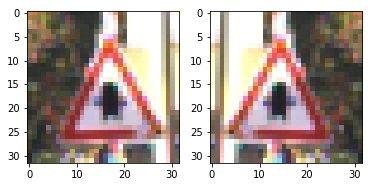

In [6]:
f,ax=plt.subplots(1,2)
ax[0].imshow(raw_X_train[idx[100]])
ax[1].imshow(nX[100])

### Symmetry in left-and-right direction
Flipping them in left-right direction give same class.

In [7]:
def ud_flip(X,y):
    labels=np.array([1, 5, 12, 15, 17,32,40])
    idx=np.in1d(y,labels)
    new_X=X[idx,::-1,:,:]
    new_y=y[idx]
    
    return new_X,new_y,np.nonzero(idx)[0]

In [8]:
uX,uy,idx=ud_flip(raw_X_train,raw_y_train)

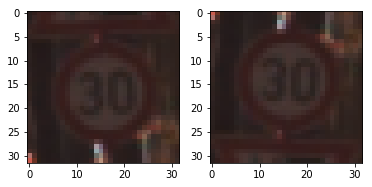

In [9]:
f,ax=plt.subplots(1,2)
ax[0].imshow(raw_X_train[idx[100]])
ax[1].imshow(uX[100])

### Symmetry between classes

Images that are flipped is belong to another class

In [10]:
def cross_flip(X,y):
        
    flip_pair=[(19, 20), (33, 34), (36, 37), (38, 39)] 
    
    pair_X=[]
    pair_y=[]
    for fp in flip_pair:
        idx_1= y==fp[0]
        idx_2= y==fp[1]
        
        nX_1=X[idx_1,:,::-1,:]
        ny_1=np.ones(nX_1.shape[0])*fp[1]
        
        nX_2=X[idx_2,:,::-1,:]
        ny_2=np.ones(nX_2.shape[0])*fp[0]
        
        pair_X.append(nX_1)
        pair_X.append(nX_2)
        
        pair_y.append(ny_1)
        pair_y.append(ny_2)
        
    return np.concatenate(pair_X,axis=0),np.concatenate(pair_y,axis=0)


In [11]:
fpX,fpy=cross_flip(raw_X_train,raw_y_train)

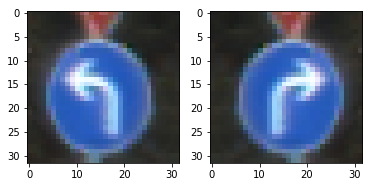

In [12]:
f,ax=plt.subplots(1,2)
ax[0].imshow(fpX[1000])
ax[1].imshow(fpX[1000,:,::-1,:])

### Warp images
Affine transformation was performed on each image. We select the coordinates (6,6), (24,6) and (6,24) as the base points, then randomly move this three points into new position by small amount of distances. A projection matrix is then generated by the original corrdinates and the destination coordinates. The affine transformation is performed with this projection matrix.

In [13]:
import cv2
def warp_image(image,move_range=3):

    # get dimensions of image
    rows,cols,ch = image.shape
    # calculate transform

    start_pt = np.float32([[6, 6],[24, 6],[6, 24]])
    transformed_pt=np.zeros_like(start_pt)
    for idx in range(3):
        lr_move=np.random.randint(-move_range,move_range+1)
        ud_move=np.random.randint(-move_range,move_range+1)
        transformed_pt[idx,0]=start_pt[idx,0]+lr_move
        transformed_pt[idx,1]=start_pt[idx,1]+ud_move


    M = cv2.getAffineTransform(start_pt,transformed_pt)
    warped = cv2.warpAffine(image,M,(cols,rows))

    return warped

def batch_warp(X):
    
    nX=np.zeros_like(X)
    for i in range(X.shape[0]):
        nX[i]=warp_image(X[i])
    
    return nX

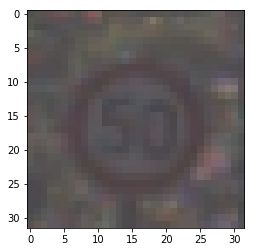

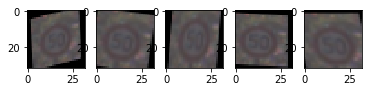

In [14]:
#choose an image
img_id=np.random.randint(raw_y_train.shape[0])
orig_img=raw_X_train[img_id]
plt.imshow(orig_img)
warp_attempt=5
f,ax=plt.subplots(1,warp_attempt)
for i in range(warp_attempt):
    ax[i].imshow(warp_image(orig_img))

In [15]:
total_warp_copy=6

X_list=[]
y_list=[]
for i in range(total_warp_copy):
    afX=batch_warp(raw_X_train)
    afy=raw_y_train
    X_list.append(afX)
    y_list.append(afy)

afX=np.concatenate(X_list,axis=0)
afy=np.concatenate(y_list,axis=0)

## Rotate images
We randomly rotate the images within 15 degrees.

In [16]:
def rotate_image(image):
    
    rows=image.shape[0]
    cols=image.shape[1]
    
    M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.uniform(-15,15),1)
    new_image = cv2.warpAffine(image,M,(cols,rows))
    return new_image
    

def batch_rotate(X):
    new_X=np.zeros_like(X)
    for i in range(X.shape[0]):
        new_X[i]=rotate_image(X[i])
    return X

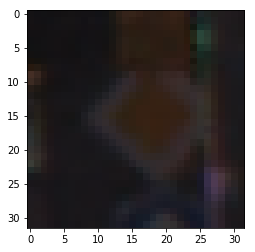

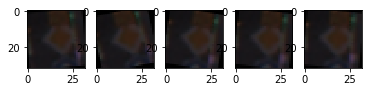

In [17]:
#choose an image
img_id=np.random.randint(raw_y_train.shape[0])
orig_img=raw_X_train[img_id]
plt.imshow(orig_img)
rotate_attempt=5
f,ax=plt.subplots(1,rotate_attempt)
for i in range(rotate_attempt):
    ax[i].imshow(rotate_image(orig_img))

In [18]:
total_warp_copy=6

X_list=[]
y_list=[]
for i in range(total_warp_copy):
    afX=batch_rotate(raw_X_train)
    afy=raw_y_train
    X_list.append(afX)
    y_list.append(afy)

rX=np.concatenate(X_list,axis=0)
ry=np.concatenate(y_list,axis=0)

## Write all the results into a file

In [19]:
aug_train={}
aug_train['horiz_sym_features']=nX
aug_train['horiz_sym_labels']=ny
aug_train['vert_sym_features']=uX
aug_train['vert_sym_labels']=uy
aug_train['fp_features']=fpX
aug_train['fp_labels']=fpy
aug_train['rotate_features']=rX
aug_train['rotate_lables']=ry
aug_train['affine_features']=afX
aug_train['affine_labels']=afy
aug_training_file=os.path.join(image_dir,"aug_train.p")
with open(aug_training_file, mode='wb') as f:
    pickle.dump(aug_train,f)